<a href="https://colab.research.google.com/github/tahoeivanova/audio_classification_genres/blob/main/neuro_audio_classification_genres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Подключаем библиотеки
from google.colab import files #Загрузка файлов
from tensorflow.keras.utils import to_categorical #Для представления в формате one_hot_encoding
import os #Работа с папками и файлами
import librosa #Параметризация аудио
import numpy as np #Numpy массивы
import matplotlib.pyplot as plt #Отображение графиков

from tensorflow.keras.optimizers import Adam, RMSprop #Подключаем оптимизаторы
from tensorflow.keras.models import Sequential, Model #Модели keras
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM #Базовые слои
from sklearn.model_selection import train_test_split #Разбиение на обучающую и проверочную выборку
from sklearn.preprocessing import LabelEncoder, StandardScaler #Для нормировки данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/NeuUni/Audio_set'
!pwd
genres = os.listdir('genres')
!ls genres

!ls genres/blues

/content/drive/MyDrive/NeuUni/Audio_set
/content/drive/MyDrive/NeuUni/Audio_set
blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock
blues.00000.au	blues.00020.au	blues.00040.au	blues.00060.au	blues.00080.au
blues.00001.au	blues.00021.au	blues.00041.au	blues.00061.au	blues.00081.au
blues.00002.au	blues.00022.au	blues.00042.au	blues.00062.au	blues.00082.au
blues.00003.au	blues.00023.au	blues.00043.au	blues.00063.au	blues.00083.au
blues.00004.au	blues.00024.au	blues.00044.au	blues.00064.au	blues.00084.au
blues.00005.au	blues.00025.au	blues.00045.au	blues.00065.au	blues.00085.au
blues.00006.au	blues.00026.au	blues.00046.au	blues.00066.au	blues.00086.au
blues.00007.au	blues.00027.au	blues.00047.au	blues.00067.au	blues.00087.au
blues.00008.au	blues.00028.au	blues.00048.au	blues.00068.au	blues.00088.au
blues.00009.au	blues.00029.au	blues.00049.au	blues.00069.au	blues.00089.au
blues.00010.au	blues.00030.au	blues.00050.au	blues.00070.au	blues.00090.au
blues.00011.au	blues.00

In [ ]:
# Функция параметризации аудио
def get_features(y, sr):
  # Получаем различные параметры аудио
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr) # Частота цветности (по умолчанию 12 баков цветности)
  mfcc = librosa.feature.mfcc(y=y, sr=sr)
  rmse = np.mean(librosa.feature.rms(y=y)) # Среднеквадратичная амплитуда
  spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)) # Среднее спектрального центроида
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)) # Среднее ширины полосы частот
  rolloff  = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)) # Среднее спектрального спада частоты
  zcr = np.mean(librosa.feature.zero_crossing_rate(y)) # Среднее частоты пересечения нуля звукового временного ряда

  # Добавляем все параметры в один список
  out=[] # Создаем пустой список
  out.append(rmse)
  out.append(spec_cent)
  out.append(spec_bw)
  out.append(rolloff)
  out.append(zcr)

  # добавляем среднне всех мел спектральных коэффициентов (20 значений)
  for e in mfcc:
    out.append(np.mean(e))

  # Добавляем среднее всех частот цветности (12 значений)
  for e in chroma_stft:
    out.append(np.mean(e))

  # Возвращаем получившийся список размерностью (37, )
  return out

                 


In [ ]:
import time 

# Формируем обучающую выборку
# Создаем пустые листы
X_train = []
Y_train = []

# Запомниаем время старта
curr_time = time.time()

# Проходим по всем жанрам
for i in range(len(genres)):
  g = genres[i] # Берем текущий жанр
  # Проходим по файлам папки, соответсвующей текущему жанру
  for filename in os.listdir(f'./genres/{g}'):
    songname = f'./genres/{g}/{filename}'
    # Загружаем в аудиосигнал
    # Используем первые 30 секунд аудио
    y, sr = librosa.load(songname, mono=True, duration=30) # y - массив данных временного ряда аудио, sr - частота дискретизации временного ряда
    # Преверащаем сигнал в параметризованные данные
    out = get_features(y, sr)

    # Добавляем сторку в X_train
    X_train.append(out)
    Y_train.append(to_categorical(i, len(genres)))
  
  # Выводим информацию о готовности обработки базы
  print('Жанр ', g, ' Готов -> ', round(time.time() - curr_time), ' c ', sep=' ')
  curr_time = time.time()

# Превращаем обучающую выборку в numpy массив
X_train = np.array(X_train)
Y_train = np.array(Y_train)


Жанр  blues  Готов ->  190  c 
Жанр  country  Готов ->  188  c 
Жанр  classical  Готов ->  179  c 
Жанр  pop  Готов ->  170  c 
Жанр  reggae  Готов ->  193  c 
Жанр  jazz  Готов ->  183  c 
Жанр  metal  Готов ->  170  c 
Жанр  hiphop  Готов ->  184  c 
Жанр  disco  Готов ->  181  c 
Жанр  rock  Готов ->  186  c 


In [ ]:
# Создаем back_up обучающей выборки
X_train_backup = X_train.copy()
Y_train_backup = Y_train.copy()

In [ ]:
# Выводим номера классов, чтбы проверить, что все правильно заполнилось
# И номера классов идут последовательно круными блоками
y_train_class = np.argmax(Y_train, axis=1)
print(y_train_class)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [ ]:
# Выводим размеры обучающей выборки
print(X_train.shape)
print(Y_train.shape)
print(y_train_class.shape)

(1000, 37)
(1000, 10)
(1000,)


In [ ]:
# Создаем scaler экземпляр класса StandartScaler() для нормировки данных
scaler = StandardScaler()
# Нормуируем X_train
X_train = scaler.fit_transform(X_train)

In [ ]:
# Проверяем, что X_train нормировался
print(X_train[0])


[-0.53326615 -0.93906628 -0.38766764 -0.64986871 -1.13821966 -0.62960812
  0.78088962  0.82329705 -0.02511461  0.33255704  0.58214735 -0.34469107
  1.26579754 -0.37534433  0.52602593  0.06759964  0.13482356  0.41475054
  0.48640389 -0.43965601 -0.04629384  0.71473746 -0.05518967  0.54382354
  0.42403525  0.67453121 -0.07192149 -0.57016065 -1.36655308 -1.54744023
 -0.40833445  0.33154614  1.44889412  0.0551163  -1.21128715 -0.78311108
 -0.33869557]


In [ ]:
# Разделяем выборку на обучающую и проверучную
# Для проверочной используем 10 % примеров
# Так как база маленькая
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_class, test_size=0.1)


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(900, 37)
(900,)
(100, 37)
(100,)


Создаем нейронку

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
45/45 [==============================] - 3s 8ms/step - loss: 2.0835 - accuracy: 0.2156 - val_loss: 1.9196 - val_accuracy: 0.2400
Epoch 2/200
45/45 [==============================] - 0s 4ms/step - loss: 1.7407 - accuracy: 0.3644 - val_loss: 1.7275 - val_accuracy: 0.3400
Epoch 3/200
45/45 [==============================] - 0s 4ms/step - loss: 1.5738 - accuracy: 0.4289 - val_loss: 1.6173 - val_accuracy: 0.3500
Epoch 4/200
45/45 [==============================] - 0s 4ms/step - loss: 1.4661 - accuracy: 0.4700 - val_loss: 1.5399 - val_accuracy: 0.4400
Epoch 5/200
45/45 [==============================] - 0s 4ms/step - loss: 1.3868 - accuracy: 0.5011 - val_loss: 1.4836 - val_accuracy: 0.4300
Epoch 6/200
45/45 [==============================] - 0s 4ms/step - loss: 1.3226 - accuracy: 0.5544 - val_loss: 1.4298 - val_accuracy: 0.4800
Epoch 7/200
45/45 [==============================] - 0s 4ms/step - loss: 1.2710 - accuracy: 0.5811 - val_loss: 1.3991 - val_accuracy: 0.5200
Epoch 8/200
4

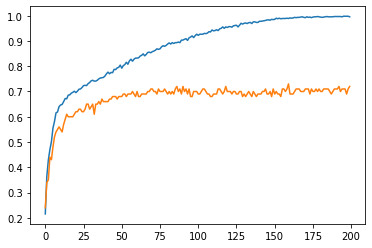

In [ ]:
# Указываем, какие индексы данных во входных векторах брать для обучения
# Делаем это для того, чтобы можно было эксперементировать
# И обучать не на всех колонках данных, а на части
indexes = range(0,37)

# Создаем полносвязную сеть
model = Sequential()
model.add(Dense(256, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(128, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(32, activation='elu'))
# В конце количество нейронов равно количеству классов и softmax
model.add(Dense(len(genres), activation='softmax'))

# Компилируем сеть
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# Обучаем
history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=200,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))
# Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

Проверка раздельно по трем блокам параметризации

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/120
45/45 [==============================] - 0s 4ms/step - loss: 2.3970 - accuracy: 0.0911 - val_loss: 2.1572 - val_accuracy: 0.1900
Epoch 2/120
45/45 [==============================] - 0s 2ms/step - loss: 2.1074 - accuracy: 0.2111 - val_loss: 1.9040 - val_accuracy: 0.3500
Epoch 3/120
45/45 [==============================] - 0s 2ms/step - loss: 1.9291 - accuracy: 0.3033 - val_loss: 1.7494 - val_accuracy: 0.4100
Epoch 4/120
45/45 [==============================] - 0s 2ms/step - loss: 1.8098 - accuracy: 0.3367 - val_loss: 1.6582 - val_accuracy: 0.4500
Epoch 5/120
45/45 [==============================] - 0s 2ms/step - loss: 1.7243 - accuracy: 0.3600 - val_loss: 1.5961 - val_accuracy: 0.4400
Epoch 6/120
45/45 [==============================] - 0s 2ms/step - loss: 1.6579 - accuracy: 0.3756 - val_loss: 1.5450 - val_accuracy: 0.4700
Epoch 7/120
45/45 [==============================] - 0s 2ms/step - loss: 1.6035 - accuracy: 0.3933 - val_loss: 1.5088 - val_accuracy: 0.5000
Epoch 8/120
4

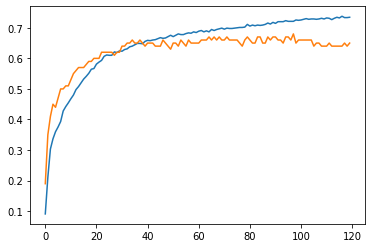

In [ ]:
# Выбираем все виды параметризации
indexes = range(0, 37)
model = Sequential()
model.add(Dense(200, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(10, activation='softmax'))
# Компилируем
model.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# обучаем
history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=120,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))
# Выводим график обучения
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/120
45/45 [==============================] - 0s 5ms/step - loss: 2.2329 - accuracy: 0.1411 - val_loss: 2.2012 - val_accuracy: 0.1300
Epoch 2/120
45/45 [==============================] - 0s 2ms/step - loss: 2.1548 - accuracy: 0.1911 - val_loss: 2.1333 - val_accuracy: 0.1900
Epoch 3/120
45/45 [==============================] - 0s 2ms/step - loss: 2.0957 - accuracy: 0.2122 - val_loss: 2.0784 - val_accuracy: 0.2300
Epoch 4/120
45/45 [==============================] - 0s 2ms/step - loss: 2.0494 - accuracy: 0.2611 - val_loss: 2.0364 - val_accuracy: 0.3000
Epoch 5/120
45/45 [==============================] - 0s 2ms/step - loss: 2.0121 - accuracy: 0.2667 - val_loss: 2.0069 - val_accuracy: 0.2800
Epoch 6/120
45/45 [==============================] - 0s 2ms/step - loss: 1.9823 - accuracy: 0.2811 - val_loss: 1.9796 - val_accuracy: 0.3000
Epoch 7/120
45/45 [==============================] - 0s 2ms/step - loss: 1.9573 - accuracy: 0.2978 - val_loss: 1.9596 - val_accuracy: 0.3300
Epoch 8/120
4

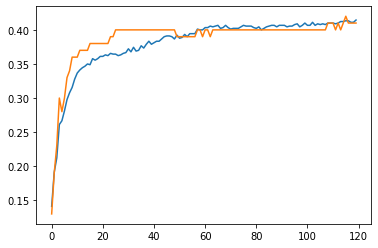

In [ ]:
# Выбираем все виды параметризации, кроме Мел коэффициетнов и частоты цветности
indexes = range(0, 5)
model = Sequential()
model.add(Dense(200, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(10, activation='softmax'))
# Компилируем
model.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# обучаем
history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=120,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))
# Выводим график обучения
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/120
45/45 [==============================] - 0s 4ms/step - loss: 2.3169 - accuracy: 0.1400 - val_loss: 2.1309 - val_accuracy: 0.2800
Epoch 2/120
45/45 [==============================] - 0s 2ms/step - loss: 2.1459 - accuracy: 0.2556 - val_loss: 1.9768 - val_accuracy: 0.3500
Epoch 3/120
45/45 [==============================] - 0s 2ms/step - loss: 2.0274 - accuracy: 0.3022 - val_loss: 1.8690 - val_accuracy: 0.4100
Epoch 4/120
45/45 [==============================] - 0s 2ms/step - loss: 1.9407 - accuracy: 0.3178 - val_loss: 1.7922 - val_accuracy: 0.4000
Epoch 5/120
45/45 [==============================] - 0s 2ms/step - loss: 1.8753 - accuracy: 0.3244 - val_loss: 1.7367 - val_accuracy: 0.4000
Epoch 6/120
45/45 [==============================] - 0s 2ms/step - loss: 1.8230 - accuracy: 0.3467 - val_loss: 1.6920 - val_accuracy: 0.4000
Epoch 7/120
45/45 [==============================] - 0s 2ms/step - loss: 1.7796 - accuracy: 0.3611 - val_loss: 1.6578 - val_accuracy: 0.4000
Epoch 8/120
4

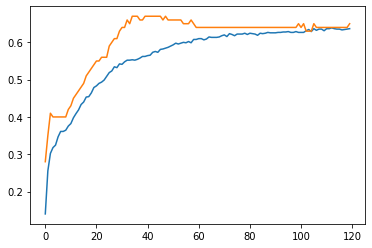

In [ ]:
# Выбираем только Мел коэффициеты
indexes = range(5, 25)
model = Sequential()
model.add(Dense(200, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(10, activation='softmax'))
# Компилируем
model.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# обучаем
history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=120,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))
# Выводим график обучения
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/120
45/45 [==============================] - 0s 4ms/step - loss: 2.2827 - accuracy: 0.1467 - val_loss: 2.2079 - val_accuracy: 0.2000
Epoch 2/120
45/45 [==============================] - 0s 2ms/step - loss: 2.1788 - accuracy: 0.1844 - val_loss: 2.1079 - val_accuracy: 0.2500
Epoch 3/120
45/45 [==============================] - 0s 2ms/step - loss: 2.1023 - accuracy: 0.2189 - val_loss: 2.0330 - val_accuracy: 0.2600
Epoch 4/120
45/45 [==============================] - 0s 2ms/step - loss: 2.0449 - accuracy: 0.2422 - val_loss: 1.9771 - val_accuracy: 0.2700
Epoch 5/120
45/45 [==============================] - 0s 2ms/step - loss: 2.0004 - accuracy: 0.2544 - val_loss: 1.9325 - val_accuracy: 0.2600
Epoch 6/120
45/45 [==============================] - 0s 2ms/step - loss: 1.9660 - accuracy: 0.2544 - val_loss: 1.9013 - val_accuracy: 0.2700
Epoch 7/120
45/45 [==============================] - 0s 2ms/step - loss: 1.9389 - accuracy: 0.2800 - val_loss: 1.8758 - val_accuracy: 0.3100
Epoch 8/120
4

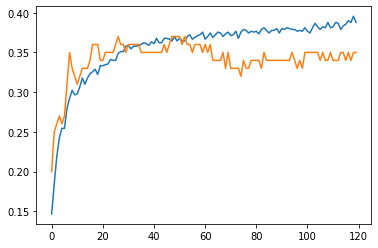

In [ ]:
# Выбираем только Частоту цветности
indexes = range(25, 37)
model = Sequential()
model.add(Dense(200, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(10, activation='softmax'))
# Компилируем
model.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# обучаем
history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=120,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))
# Выводим график обучения
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/120
45/45 [==============================] - 0s 5ms/step - loss: 2.2902 - accuracy: 0.1511 - val_loss: 2.1942 - val_accuracy: 0.2200
Epoch 2/120
45/45 [==============================] - 0s 2ms/step - loss: 2.0612 - accuracy: 0.2756 - val_loss: 1.9695 - val_accuracy: 0.3600
Epoch 3/120
45/45 [==============================] - 0s 2ms/step - loss: 1.9125 - accuracy: 0.3322 - val_loss: 1.8272 - val_accuracy: 0.4200
Epoch 4/120
45/45 [==============================] - 0s 2ms/step - loss: 1.8124 - accuracy: 0.3622 - val_loss: 1.7318 - val_accuracy: 0.4300
Epoch 5/120
45/45 [==============================] - 0s 2ms/step - loss: 1.7401 - accuracy: 0.3911 - val_loss: 1.6653 - val_accuracy: 0.4300
Epoch 6/120
45/45 [==============================] - 0s 2ms/step - loss: 1.6844 - accuracy: 0.4111 - val_loss: 1.6116 - val_accuracy: 0.4400
Epoch 7/120
45/45 [==============================] - 0s 2ms/step - loss: 1.6382 - accuracy: 0.4222 - val_loss: 1.5726 - val_accuracy: 0.4500
Epoch 8/120
4

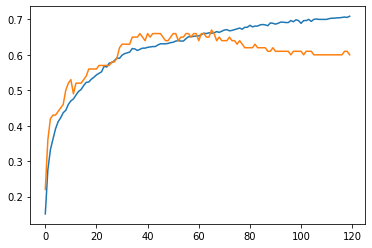

In [ ]:
# Выбираем Мел спектралльные коэффициенты и Частоты цветности
indexes = range(5, 37)
model = Sequential()
model.add(Dense(200, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(10, activation='softmax'))
# Компилируем
model.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# обучаем
history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=120,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))
# Выводим график обучения
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/120
45/45 [==============================] - 0s 4ms/step - loss: 2.3266 - accuracy: 0.1500 - val_loss: 2.1000 - val_accuracy: 0.2100
Epoch 2/120
45/45 [==============================] - 0s 2ms/step - loss: 2.1014 - accuracy: 0.2311 - val_loss: 1.9144 - val_accuracy: 0.3700
Epoch 3/120
45/45 [==============================] - 0s 2ms/step - loss: 1.9476 - accuracy: 0.3289 - val_loss: 1.7916 - val_accuracy: 0.4200
Epoch 4/120
45/45 [==============================] - 0s 2ms/step - loss: 1.8428 - accuracy: 0.3722 - val_loss: 1.7101 - val_accuracy: 0.4300
Epoch 5/120
45/45 [==============================] - 0s 2ms/step - loss: 1.7667 - accuracy: 0.3878 - val_loss: 1.6536 - val_accuracy: 0.4500
Epoch 6/120
45/45 [==============================] - 0s 2ms/step - loss: 1.7107 - accuracy: 0.3900 - val_loss: 1.6109 - val_accuracy: 0.4500
Epoch 7/120
45/45 [==============================] - 0s 2ms/step - loss: 1.6659 - accuracy: 0.4000 - val_loss: 1.5786 - val_accuracy: 0.4700
Epoch 8/120
4

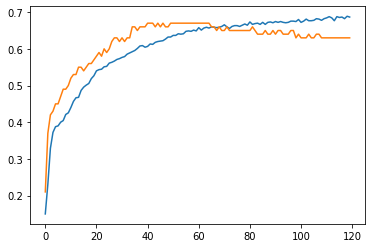

In [ ]:
# Выбираем  все параметры, кроме Частоты цветности
indexes = range(0, 25)
model = Sequential()
model.add(Dense(200, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(10, activation='softmax'))
# Компилируем
model.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# обучаем
history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=120,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))
# Выводим график обучения
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/120
45/45 [==============================] - 0s 4ms/step - loss: 2.2183 - accuracy: 0.1667 - val_loss: 2.0787 - val_accuracy: 0.2500
Epoch 2/120
45/45 [==============================] - 0s 2ms/step - loss: 2.0693 - accuracy: 0.2556 - val_loss: 1.9503 - val_accuracy: 0.3300
Epoch 3/120
45/45 [==============================] - 0s 2ms/step - loss: 1.9610 - accuracy: 0.2978 - val_loss: 1.8542 - val_accuracy: 0.3600
Epoch 4/120
45/45 [==============================] - 0s 2ms/step - loss: 1.8781 - accuracy: 0.3167 - val_loss: 1.7815 - val_accuracy: 0.4000
Epoch 5/120
45/45 [==============================] - 0s 2ms/step - loss: 1.8124 - accuracy: 0.3322 - val_loss: 1.7231 - val_accuracy: 0.4100
Epoch 6/120
45/45 [==============================] - 0s 2ms/step - loss: 1.7584 - accuracy: 0.3511 - val_loss: 1.6781 - val_accuracy: 0.4200
Epoch 7/120
45/45 [==============================] - 0s 3ms/step - loss: 1.7131 - accuracy: 0.3722 - val_loss: 1.6397 - val_accuracy: 0.4400
Epoch 8/120
4

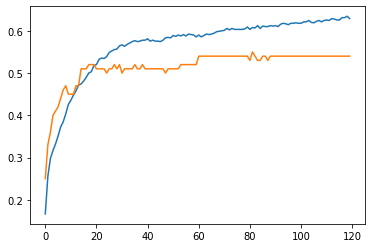

In [ ]:
# Выбираем  все параметры с шагом в 2
indexes = range(0, 37, 2)
model = Sequential()
model.add(Dense(200, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(10, activation='softmax'))
# Компилируем
model.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# обучаем
history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=120,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))
# Выводим график обучения
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

Преобразуем данные и добавим их в обучающую и проверочную выборки 


In [ ]:
# Квадрат значений
X_train_sqr = np.array([[t**2 for t in x] for x in X_train])
X_test_sqr = np.array([[t**2 for t in x] for x in X_test])
# Квадратный корень из абсолютных значений
X_train_sqrt = np.array([[abs(t)**0.5 for t in x] for x in X_train])
X_test_sqrt = np.array([[abs(t)**0.5 for t in x] for x in X_test])
# 1/t
X_train_inv = np.array([[t**(-1) for t in x] for x in X_train])
X_test_inv = np.array([[t**(-1) for t in x] for x in X_test])
# 2 в степени t
X_train_exp = np.array([[2**t for t in x] for x in X_train])
X_test_exp = np.array([[2**t for t in x] for x in X_test])
# Объединяем все массивы (Функция hstack() соединяет все массивы по горизонтали)
X_train_2 = np.hstack([X_train, X_train_sqr, X_train_sqrt, X_train_inv, X_train_exp])
X_test_2 =  np.hstack([X_test, X_test_sqr, X_test_sqrt, X_test_inv, X_test_exp])

print(X_train_2.shape)
print(X_test_2.shape)

(900, 185)
(100, 185)


In [ ]:
print(X_train_2[0])

[-0.75347109 -1.04364049 -0.7920442  -0.99228891 -1.01131179 -0.89119084
  0.67445236  0.2652103   0.19496957  0.40961871  0.3554197   0.1446963
 -0.54384737 -0.96404052  1.23990282  1.15340948 -0.28809779  0.57666562
  1.32968247  0.75114833 -1.10428352 -0.11242526 -0.1343984   0.96502024
 -0.25808506 -1.28389007 -1.55391788 -2.02360816 -1.14315406  0.18630647
 -1.0141299  -0.90550432 -0.53180957  0.78989476  1.41706788 -0.60533491
 -1.11429022  0.56771869  1.08918547  0.62733401  0.98463729  1.02275153
  0.79422111  0.45488599  0.0703365   0.03801313  0.16778749  0.12632316
  0.02093702  0.29576996  0.92937413  1.537359    1.33035342  0.08300034
  0.33254324  1.76805546  0.56422381  1.2194421   0.01263944  0.01806293
  0.93126406  0.0666079   1.64837371  2.41466079  4.09498997  1.30680121
  0.0347101   1.02845945  0.81993807  0.28282141  0.62393373  2.00808139
  0.36643036  1.24164269  0.86802713  1.02158724  0.88996865  0.996137
  1.00563999  0.94402904  0.82125049  0.51498573  0.44

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/120
45/45 [==============================] - 0s 4ms/step - loss: 26.6873 - accuracy: 0.1033 - val_loss: 50.5914 - val_accuracy: 0.0800
Epoch 2/120
45/45 [==============================] - 0s 2ms/step - loss: 23.3054 - accuracy: 0.1322 - val_loss: 44.7567 - val_accuracy: 0.1200
Epoch 3/120
45/45 [==============================] - 0s 2ms/step - loss: 20.5564 - accuracy: 0.1644 - val_loss: 39.5762 - val_accuracy: 0.1700
Epoch 4/120
45/45 [==============================] - 0s 2ms/step - loss: 17.9560 - accuracy: 0.1878 - val_loss: 35.8539 - val_accuracy: 0.1800
Epoch 5/120
45/45 [==============================] - 0s 2ms/step - loss: 15.7772 - accuracy: 0.2133 - val_loss: 33.3110 - val_accuracy: 0.2000
Epoch 6/120
45/45 [==============================] - 0s 2ms/step - loss: 13.7207 - accuracy: 0.2378 - val_loss: 32.4450 - val_accuracy: 0.2000
Epoch 7/120
45/45 [==============================] - 0s 2ms/step - loss: 11.8968 - accuracy: 0.2578 - val_loss: 31.0565 - val_accuracy: 0.2100

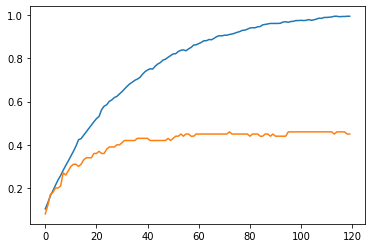

In [ ]:
# Создаем сеть
model = Sequential()
model.add(Dense(200, activation='elu', input_shape=(X_train_2.shape[1], )))
model.add(Dense(10, activation='softmax'))
# Компилируем 
model.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# обучаем
history = model.fit(X_train_2,
                    y_train,
                    epochs=120,
                    batch_size=20,
                    validation_data=(X_test_2, y_test))
# Выводим график обучения
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()


In [ ]:
!pip install pip install pydub

In [ ]:

from os import path
from pydub import AudioSegment

# files                                                                         
# src = '/content/drive/MyDrive/NeuUni/Audio_set/Predict/Deftones - Be Quiet and Drive (Far Away).mp3'
# dst = '/content/drive/MyDrive/NeuUni/Audio_set/Predict/Deftones - Be Quiet and Drive (Far Away).wav'

# src = '/content/drive/MyDrive/NeuUni/Audio_set/Predict/Bob_Marley_-_No_Woman_No_Cry_(musmore.com).mp3'
# dst = '/content/drive/MyDrive/NeuUni/Audio_set/Predict/Bob_Marley_-_No_Woman_No_Cry_(musmore.com).wav'

src = '/content/drive/MyDrive/NeuUni/Audio_set/Predict/Ed Sheeran — Perfect.mp3'
dst = '/content/drive/MyDrive/NeuUni/Audio_set/Predict/Ed Sheeran — Perfect.wav'

# convert wav to mp3                                                            
sound = AudioSegment.from_mp3(src)
sound.export(dst, format="wav")

<_io.BufferedRandom name='/content/drive/MyDrive/NeuUni/Audio_set/Predict/Ed Sheeran — Perfect.wav'>

Распознавание выбранной песни

In [ ]:
# Выбирем песню для распознавания
# songname = './genres/rock/rock.00000.au'
songname = '/content/drive/MyDrive/NeuUni/Audio_set/Predict/Ed Sheeran — Perfect.wav'
# Получаем аудио сигнал
y, sr = librosa.load(songname, mono=True, duration=30)
# Параметризуем сигнал
out = get_features(y, sr)

In [ ]:
# Добавляем одну размерность, этого требует model.predict
out = np.array(out).reshape(1, 37)


In [ ]:
# Проверяем размерность
out.shape

(1, 37)

In [ ]:
# Делаем преобразование с помощью scaler, обученного на обучающей выборке
out = scaler.transform(out)

In [ ]:
print(out)

[[-0.06505362 -0.49779162 -0.53975141 -0.54077243 -0.54486819 -0.37826307
   0.68606082  0.55008343 -0.32492039 -0.54377558 -1.37738657  0.47612137
  -1.99945177 -0.76953907 -1.16703914 -1.86375068 -1.28156621 -2.59570673
  -4.23419518 -1.62849    -2.21715466 -2.38745739 -0.20090355 -0.97244438
  -1.06014673  0.13491231 -0.60004874 -1.30553083  0.78707602 -1.42840245
  -0.95351597 -1.7966004  -0.78159183  1.42432646 -1.42903202 -1.58958608
  -1.58369217]]


In [ ]:
y = model.predict(out)

In [ ]:
# Выводим вызод с softmax
print(y)
# и распознанный класс
print(np.argmax(y))
# Проверяем правльноый индекс исходного жанра
print(genres.index('country'))

[[8.2408125e-04 9.2440009e-01 1.9985612e-06 3.6969548e-04 7.3970594e-02
  3.7663139e-07 9.2542134e-05 5.5345296e-05 2.6661399e-04 1.8723222e-05]]
1
1
